In [1]:
%load_ext autoreload
%autoreload 2


In [3]:
pwd

'/Users/iw2g24/PycharmProjects/SSH_project/functioning_scripts'

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import xeofs as xe
from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import warnings
import os
warnings.filterwarnings('ignore')



ModuleNotFoundError: No module named 'geometry_izzyv1'

In [4]:
# constant
rho_a = 1.225 # air density kg m-3

Cd = 1.5e-3 # drag coeff

In [5]:
gridtype = 'remapcon'

In [6]:
# dot dataset
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')

/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

<xarray.Dataset> Size: 2MB
Dimensions:                           (tdim: 1, y: 332, x: 316)
Coordinates:
    time                              (tdim) datetime64[ns] 8B ...
    xgrid                             (x) float32 1kB ...
    ygrid                             (y) float32 1kB ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly           (tdim, y, x) float32 420kB ...
    nsidc_bt_seaice_conc_monthly      (tdim, y, x) float32 420kB ...
    nsidc_nt_seaice_conc_monthly      (tdim, y, x) float32 420kB ...
    projection                        |S1 1B ...
    qa_of_cdr_seaice_conc_monthly     (tdim, y, x) float32 420kB ...
    stdev_of_cdr_seaice_conc_monthly  (tdim, y, x) float32 420kB ...
Attributes: (12/42)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_var

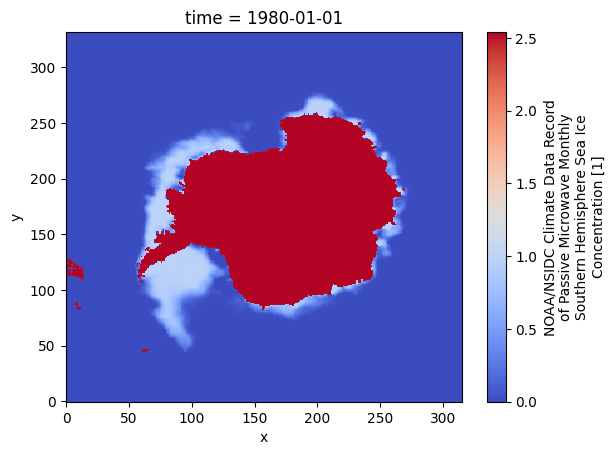

(316,)
(332,)


In [11]:
#sea ice drift data from nsidc
directory = "/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/si_conc_nsidc_G02202_V4/"
ds_example = xr.open_dataset(directory + 'seaice_conc_monthly_sh_197902_n07_v04r00.nc')
print(ds_example)
print(ds_example['xgrid'])

ds_example2 = xr.open_dataset(directory + 'seaice_conc_monthly_sh_198001_n07_v04r00.nc')
print(ds_example2)
print(ds_example2['xgrid'])

variable_name = "cdr_seaice_conc_monthly"

# Extract the data array for plotting
data_to_plot = ds_example2[variable_name].isel(tdim=0)
print("plotted data size",data_to_plot.shape)

# Plot using xarray's built-in method
data_to_plot.plot(cmap="coolwarm")  # Replace 'viridis' with your preferred color map
#plt.title(f"{variable_name} at time {ds_example['time']}")
plt.show()

print(ds_example2["xgrid"].shape)
print(ds_example2["ygrid"].shape)

In [12]:
print(ds_example2["cdr_seaice_conc_monthly"].attrs)

{'long_name': 'NOAA/NSIDC Climate Data Record of Passive Microwave Monthly Southern Hemisphere Sea Ice Concentration', 'standard_name': 'sea_ice_area_fraction', 'units': '1', 'flag_values': array([251, 252, 253, 254, 255], dtype=uint8), 'flag_meanings': 'pole_hole lakes coastal land_mask missing_data', 'datum': '+ellps=urn:ogc:def:crs:EPSG::4326', 'grid_mapping': 'projection', 'reference': 'https://nsidc.org/data/g02202/versions/4/', 'ancillary_variables': 'stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_conc_monthly', 'valid_range': array([  0, 100], dtype=uint8)}


In [13]:
print(ds_example2.variables)


Frozen({'cdr_seaice_conc_monthly': <xarray.Variable (tdim: 1, y: 332, x: 316)> Size: 420kB
[104912 values with dtype=float32]
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100], 'nsidc_bt_seaice_conc_monthly': <xarray.Variable (tdim: 1, y: 332, x: 316)> Size: 420kB
[104912 values with dtype=float32]
Attributes:
    long_name:      Passive Microwave Monthly Southern Hemisphere Sea Ice Con...
    standard_name:  sea_ice_area_fraction
    units:          1
    flag_values:    [

In [14]:
ds_check = xr.open_dataset('nsidc_conc2.nc')
print(ds_check)

<xarray.Dataset> Size: 1GB
Dimensions:                           (time_new: 548, tdim: 1, y: 332, x: 316)
Coordinates:
    time                              (time_new, tdim) datetime64[ns] 4kB ...
    xgrid                             (x) float32 1kB ...
    ygrid                             (y) float32 1kB ...
    lon                               (y, x) float64 839kB ...
    lat                               (y, x) float64 839kB ...
  * time_new                          (time_new) datetime64[ns] 4kB 1978-11-0...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly           (time_new, tdim, y, x) float32 230MB ...
    nsidc_bt_seaice_conc_monthly      (time_new, tdim, y, x) float32 230MB ...
    nsidc_nt_seaice_conc_monthly      (time_new, tdim, y, x) float32 230MB ...
    projection                        (time_new) |S1 548B ...
    qa_of_cdr_seaice_conc_monthly     (time_new, tdim, y, x) float32 230MB ...
    stdev_of_cdr_seaice_conc_monthly  (time

In [15]:
ds_nsidc_conc = xr.open_dataset('nsidc_conc2.nc')
print(ds_nsidc_conc)

<xarray.Dataset> Size: 1GB
Dimensions:                           (time_new: 548, tdim: 1, y: 332, x: 316)
Coordinates:
    time                              (time_new, tdim) datetime64[ns] 4kB ...
    xgrid                             (x) float32 1kB ...
    ygrid                             (y) float32 1kB ...
    lon                               (y, x) float64 839kB ...
    lat                               (y, x) float64 839kB ...
  * time_new                          (time_new) datetime64[ns] 4kB 1978-11-0...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly           (time_new, tdim, y, x) float32 230MB ...
    nsidc_bt_seaice_conc_monthly      (time_new, tdim, y, x) float32 230MB ...
    nsidc_nt_seaice_conc_monthly      (time_new, tdim, y, x) float32 230MB ...
    projection                        (time_new) |S1 548B ...
    qa_of_cdr_seaice_conc_monthly     (time_new, tdim, y, x) float32 230MB ...
    stdev_of_cdr_seaice_conc_monthly  (time

In [33]:
print("xgrid shape:", ds_nsidc_conc["xgrid"].shape)
print("ygrid shape:", ds_nsidc_conc["ygrid"].shape)
print("Data to plot shape:", data_to_plot.isel(time_new = 0, tdim=0).shape)


xgrid shape: (316,)
ygrid shape: (332,)
Data to plot shape: (332, 316)


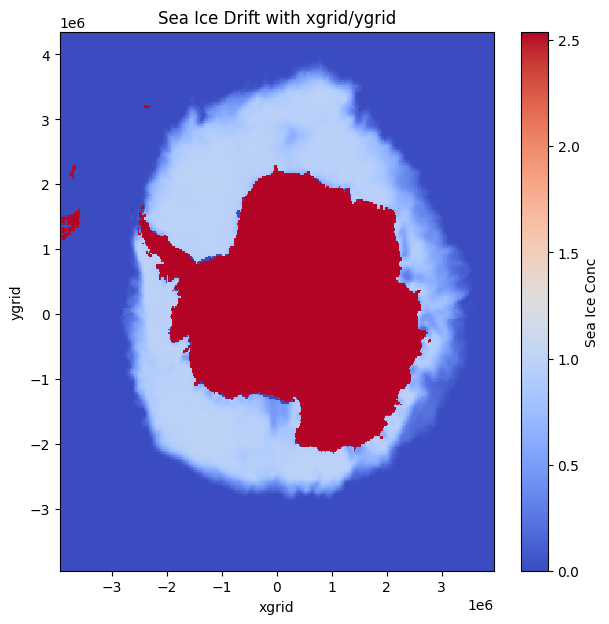

In [34]:
# Plot sea ice conc using x and y coordinates
data_to_plot = ds_nsidc_conc["cdr_seaice_conc_monthly"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_nsidc_conc["xgrid"],
    ds_nsidc_conc["ygrid"],
    data_to_plot.isel(time_new=0, tdim=0),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Conc")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("xgrid")
plt.ylabel("ygrid")
plt.show()


In [35]:
print("Data shape:", ds_nsidc_conc["cdr_seaice_conc_monthly"].isel(tdim=0).shape)
print("Longitude shape:", ds_nsidc_conc["lon"].shape)
print("Latitude shape:", ds_nsidc_conc["lat"].shape)


Data shape: (548, 332, 316)
Longitude shape: (332, 316)
Latitude shape: (332, 316)


In [36]:
print(ds_nsidc_conc["lon"])

<xarray.DataArray 'lon' (y: 332, x: 316)> Size: 839kB
[104912 values with dtype=float64]
Coordinates:
    xgrid    (x) float32 1kB -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    ygrid    (y) float32 1kB 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
    lon      (y, x) float64 839kB ...
    lat      (y, x) float64 839kB ...
Dimensions without coordinates: y, x


In [37]:
print(ds_nsidc_conc.values)
print(ds_nsidc_conc['lon'].shape)
print(ds_nsidc_conc['lat'].shape)

<bound method Mapping.values of <xarray.Dataset> Size: 1GB
Dimensions:                           (time_new: 548, tdim: 1, y: 332, x: 316)
Coordinates:
    time                              (time_new, tdim) datetime64[ns] 4kB ...
    xgrid                             (x) float32 1kB -3.938e+06 ... 3.938e+06
    ygrid                             (y) float32 1kB 4.338e+06 ... -3.938e+06
    lon                               (y, x) float64 839kB ...
    lat                               (y, x) float64 839kB ...
  * time_new                          (time_new) datetime64[ns] 4kB 1978-11-0...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly           (time_new, tdim, y, x) float32 230MB ...
    nsidc_bt_seaice_conc_monthly      (time_new, tdim, y, x) float32 230MB ...
    nsidc_nt_seaice_conc_monthly      (time_new, tdim, y, x) float32 230MB ...
    projection                        (time_new) |S1 548B ...
    qa_of_cdr_seaice_conc_monthly     (time_new,

In [38]:
time_nsidc = ds_nsidc_conc['time_new'].values
print("nsidc conc time", time_nsidc[284],time_nsidc[479])

nsidc conc time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000


In [39]:
#reorder ds_nsidc_conc  to have time_new, lat, lon

# Open the dataset
ds_nsidc_conc = xr.open_dataset("nsidc_conc2.nc")

# Step 1: Extract lat, lon, and sea ice concentration
lat_nsidc = ds_nsidc_conc['lat'].values  # Shape (y, x)
lon_nsidc = ds_nsidc_conc['lon'].values  # Shape (y, x)
time_new = ds_nsidc_conc['time_new'].values  # Shape (time_new)

# Step 2: Flatten the lat and lon arrays into 1D arrays
lat_flat = lat_nsidc.flatten()
lon_flat = lon_nsidc.flatten()

# Step 3: Reshape the variable (e.g., 'sea_ice_conc') to match the flattened grid
# Assuming the variable of interest is named 'sea_ice_conc' or similar
var = ds_check['cdr_seaice_conc_monthly'].values  # Shape (time_new, tdim, y, x)

# Remove 'tdim' dimension by squeezing it
var_squeezed = var[:, 0, :, :]  # Shape becomes (time_new, y, x)

# Flatten 'y' and 'x' into a single dimension
var_flat = var_squeezed.reshape((var_squeezed.shape[0], -1))  # Shape (time_new, y*x)

# Step 4: Create a new dataset with dimensions (time_new, lat, lon)
ds_reordered = xr.Dataset(
    data_vars={
        'si_conc': (['time_new', 'points'], var_flat)  # Data flattened
    },
    coords={
        'time_new': time_new,      # Time dimension
        'lat': ('points', lat_flat),  # 1D lat coordinate
        'lon': ('points', lon_flat)   # 1D lon coordinate
    }
)

# Step 5: Verify the new dataset
print(ds_reordered)

# Step 6: Save the new dataset
output_file = "reordered_sea_ice_concentration.nc"
ds_reordered.to_netcdf(output_file)
print(f"Reordered dataset saved to: {output_file}")


<xarray.Dataset> Size: 232MB
Dimensions:   (time_new: 548, points: 104912)
Coordinates:
  * time_new  (time_new) datetime64[ns] 4kB 1978-11-01 1978-12-01 ... 2024-06-01
    lat       (points) float64 839kB -39.36 -39.49 -39.62 ... -41.72 -41.58
    lon       (points) float64 839kB -42.23 -42.05 -41.87 ... 135.4 135.2 135.0
Dimensions without coordinates: points
Data variables:
    si_conc   (time_new, points) float32 230MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Reordered dataset saved to: reordered_sea_ice_concentration.nc


In [40]:
print(f"Number of points: {lat_flat.shape[0]} (should be equal to y * x)")
print(f"Sea Ice Concentration reshaped to: {var_flat.shape}")
print(332*316)

Number of points: 104912 (should be equal to y * x)
Sea Ice Concentration reshaped to: (548, 104912)
104912


In [41]:
# change coordinates from (lon,lat,time) to (time,lat,lon) as ERA5
lon_dot = ds['longitude'].values; lat_dot = ds['latitude'].values
dot_all = ds['dot'].values
dot = np.zeros((dot_all.shape[2], dot_all.shape[1], dot_all.shape[0]))
for t in range(0,dot_all.shape[2]):
    for i in range(0,dot_all.shape[1]):
        for j in range(0,dot_all.shape[0]):
            dot[t,i,j] = dot_all[j,i,t].copy()
seamask = dot[0].copy()/dot[0]
seamask[seamask == 0] = np.nan
del dot_all

In [42]:
# make lon lat 2d
llon = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[1]):
    llon[i,:] = lon_dot
llat = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[2]):
    llat[:,i] = lat_dot

In [43]:
print(dot.shape)
print(llon.shape)
print(llat.shape)
print(dot[0].shape)

(196, 64, 360)
(64, 360)
(64, 360)
(64, 360)


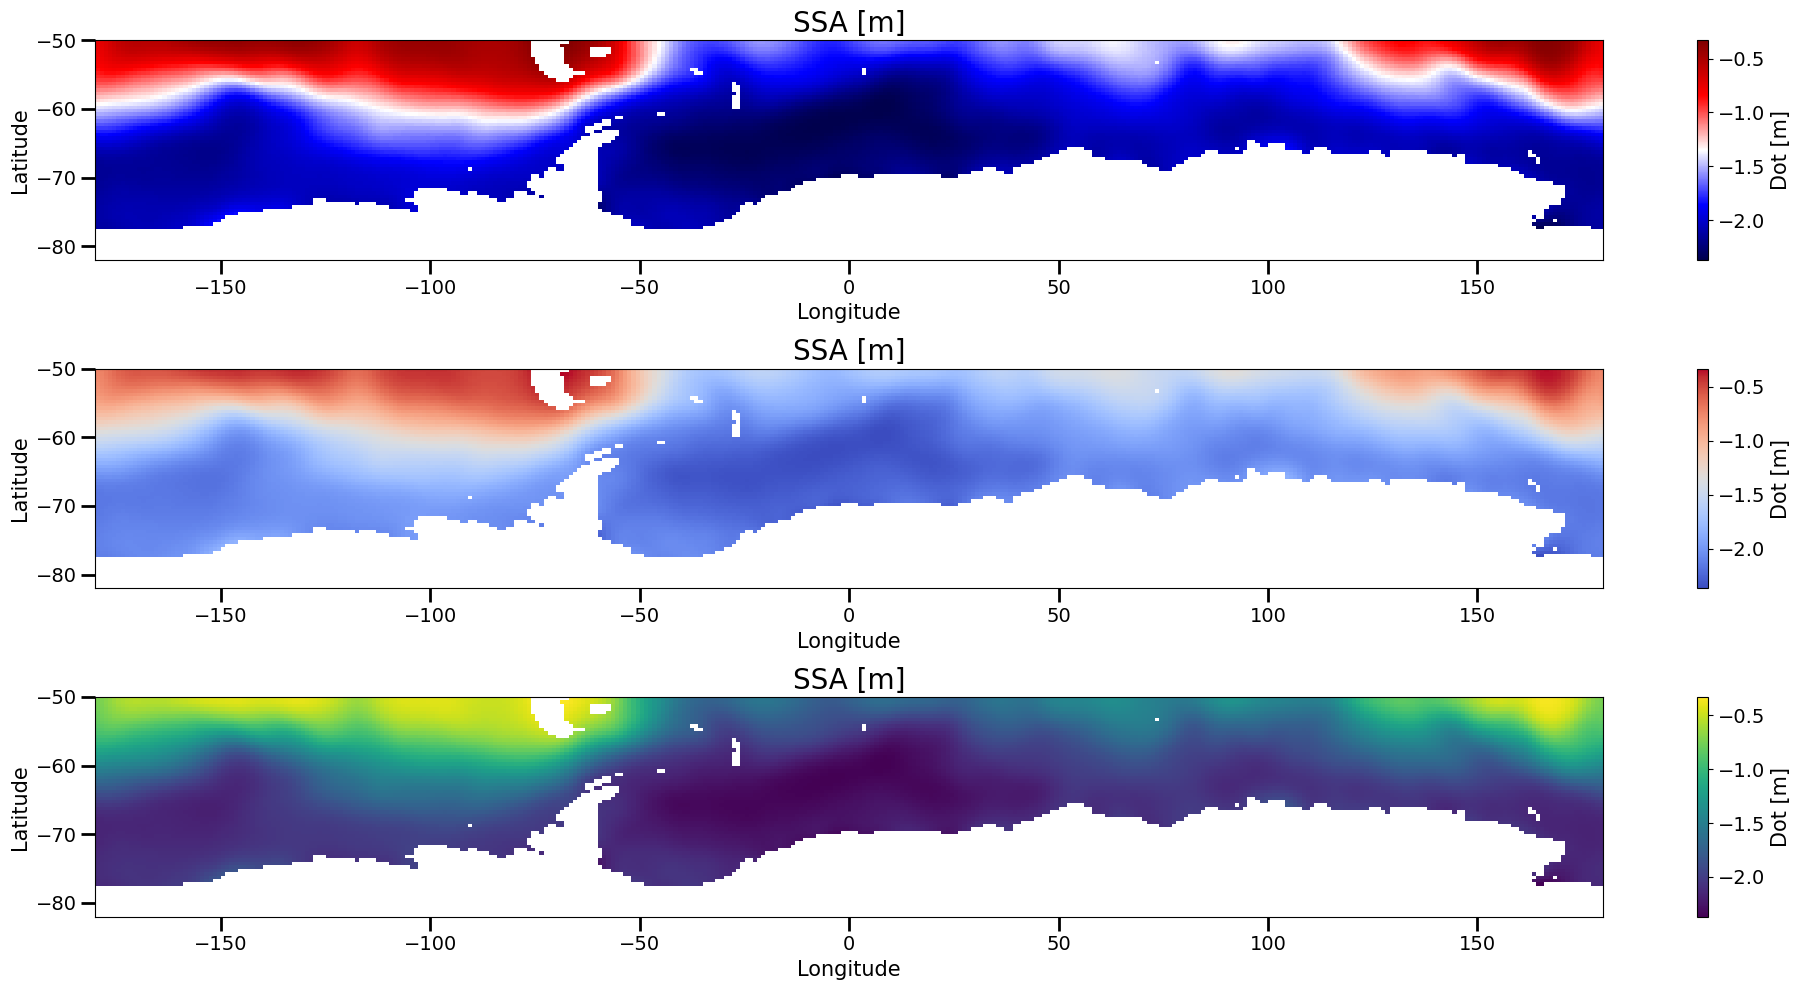

In [44]:
#plot dot with different colour schemes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

pc1 = axes[0].pcolormesh(llon,llat,dot[0], cmap='seismic')
axes[0].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[0].set_title('SSA [m]', fontsize=20)
axes[0].set_xlabel('Longitude', fontsize=15)
axes[0].set_ylabel('Latitude', fontsize=15)
cbar1 = fig.colorbar(pc1, ax=axes[0])
cbar1.set_label('Dot [m]', fontsize=15)
cbar1.ax.tick_params(labelsize=14)

pc2 = axes[1].pcolormesh(llon,llat,dot[0], cmap='coolwarm')
axes[1].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[1].set_title('SSA [m]', fontsize=20)
axes[1].set_xlabel('Longitude', fontsize=15)
axes[1].set_ylabel('Latitude', fontsize=15)
cbar2 = fig.colorbar(pc2, ax=axes[1])
cbar2.set_label('Dot [m]', fontsize=15)
cbar2.ax.tick_params(labelsize=14)

pc3 = axes[2].pcolormesh(llon,llat,dot[0], cmap='viridis')
axes[2].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[2].set_title('SSA [m]', fontsize=20)
axes[2].set_xlabel('Longitude', fontsize=15)
axes[2].set_ylabel('Latitude', fontsize=15)
cbar3 = fig.colorbar(pc3, ax=axes[2])
cbar3.set_label('Dot [m]', fontsize=15)
cbar3.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [45]:
# time
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values
time_nsidc = ds_nsidc_conc['time_new'].values

In [46]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
time_nsidc_array = np.array(time_nsidc, dtype='datetime64[ns]')

indices_dot_nsidc = np.where(np.isin(time_nsidc_array, time_dot_array))
print(indices_dot_nsidc)

(array([284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
       297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,
       323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335,
       336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348,
       349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
       375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387,
       388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400,
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 4

In [47]:
#print(time_era5)
print("dot time", time_dot[0],time_dot[-1])
print("era5 time", time_era5[30],time_era5[225])
print("nsidc conc time", time_nsidc[284],time_nsidc[479])

dot time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
era5 time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
nsidc conc time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000


In [48]:
tstart_era5 = 30
tend_era5 = 226 # +1 respect cell above

tstart_nsidc = 284
tend_nsidc = 480 #+1 respect cell above

In [49]:
# select sea ice concentration
seaice_concentration = ds_nsidc_conc['cdr_seaice_conc_monthly'][tstart_nsidc:tend_nsidc].values
print(seaice_concentration.shape)
print(seaice_concentration.max())

(196, 1, 332, 316)
2.54


In [50]:
# DE-TREND DOT

In [51]:
# linear regression in time on each grid point
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot)
# remove trend for dot
xt = np.zeros(dot.shape)
for t in range(0,dot.shape[0]):
    xt[t] = t
dot_detrended = dot - (slope*xt + intercept)

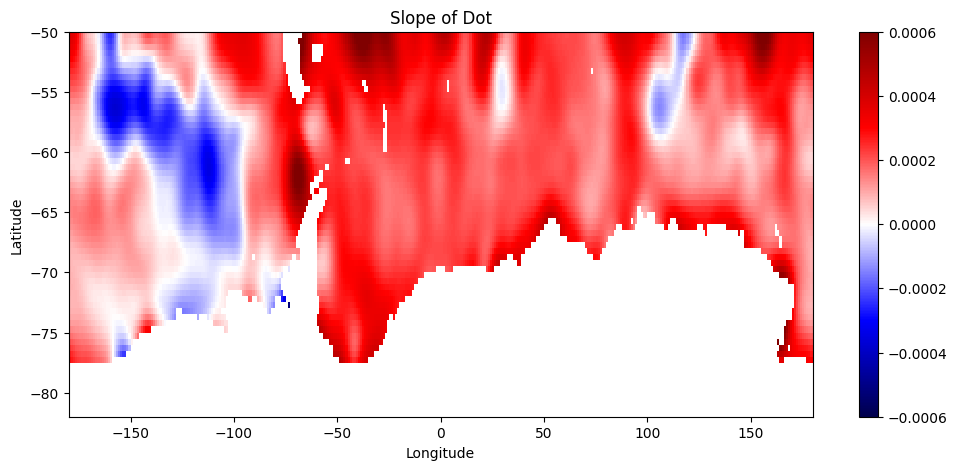

In [52]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope, vmin=-6e-4, vmax=6e-4, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Dot')
plt.colorbar()


In [53]:
dot_final = dot_detrended.copy()

In [54]:
seaice_concentration = ds_nsidc_conc['cdr_seaice_conc_monthly'][tstart_nsidc:tend_nsidc].values
print(seaice_concentration.shape)

# Assuming 'time_new' is the time coordinate in the dataset
time_values = ds_nsidc_conc['time_new'][tstart_nsidc:tend_nsidc].values
print(time_values.shape)  # To verify the shape


(196, 1, 332, 316)
(196,)


In [55]:
print(seaice_concentration.shape)
print((seaice_concentration).shape[0])
print((seaice_concentration[t,0]).shape)


(196, 1, 332, 316)
196
(332, 316)


In [56]:
#remap data onto dot grid
# Target grid
lon_target = ds['longitude'].values  # (360,)
lat_target = ds['latitude'].values  # (64,)

# Create an empty list to store regridded data
regridded_data_list = []
time_steps_list = []


# Loop through each time step of the original sea ice data
for t in range(seaice_concentration.shape[0]):  # Loop over the time dimension
    # Extracting the sea ice concentration at time t, shape (332, 316)
    seaice = seaice_concentration[t, 0]

    # Coordinates for the original grid
    lon_seaice = lon_nsidc  # (332, 316)
    lat_seaice = lat_nsidc  # (332, 316)

    # Flatten original grid and sea ice data
    points = np.array([lon_seaice.flatten(), lat_seaice.flatten()]).T  # [lon, lat]
    values = seaice.flatten()

    # Generate target grid (meshgrid for lon and lat)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)  # 2D target grid

    # Interpolate onto the target grid
    seaice_regridded = griddata(points, values, (lon_mesh, lat_mesh), method='linear')

    # Add regridded data to list (append 2D array for this time step)
    regridded_data_list.append(seaice_regridded)

    # Store the corresponding time value
    time_steps_list.append(time_values[t])  # Add the corresponding time step

# Stack the regridded data along the time dimension
regridded_seaice_conc = np.stack(regridded_data_list, axis=0)  # Shape: (time, lat, lon)

# Now you can use regridded_data, and time_steps_list to refer to the time dimension
print(f"Regridded data shape: {regridded_seaice_conc.shape}")
#print(f"Time steps: {time_steps_list}")


Regridded data shape: (196, 64, 360)


In [57]:
# Create a new xarray DataArray with regridded data
regridded_seaice_da = xr.DataArray(
    regridded_seaice_conc,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Assuming time steps are just integers
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_concentration",  # Variable name
)

# Create a Dataset with the regridded DataArray
regridded_seaice_ds = xr.Dataset(
    {"seaice_concentration": regridded_seaice_da}
)

# Print dataset to verify
print(regridded_seaice_ds)


<xarray.Dataset> Size: 36MB
Dimensions:               (time: 196, lat: 64, lon: 360)
Coordinates:
  * time                  (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat                   (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                   (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    seaice_concentration  (time, lat, lon) float64 36MB nan 2.54 ... nan nan


<xarray.Dataset> Size: 36MB
Dimensions:               (time: 196, lat: 64, lon: 360)
Coordinates:
  * time                  (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat                   (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                   (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    seaice_concentration  (time, lat, lon) float64 36MB nan 2.54 ... nan nan


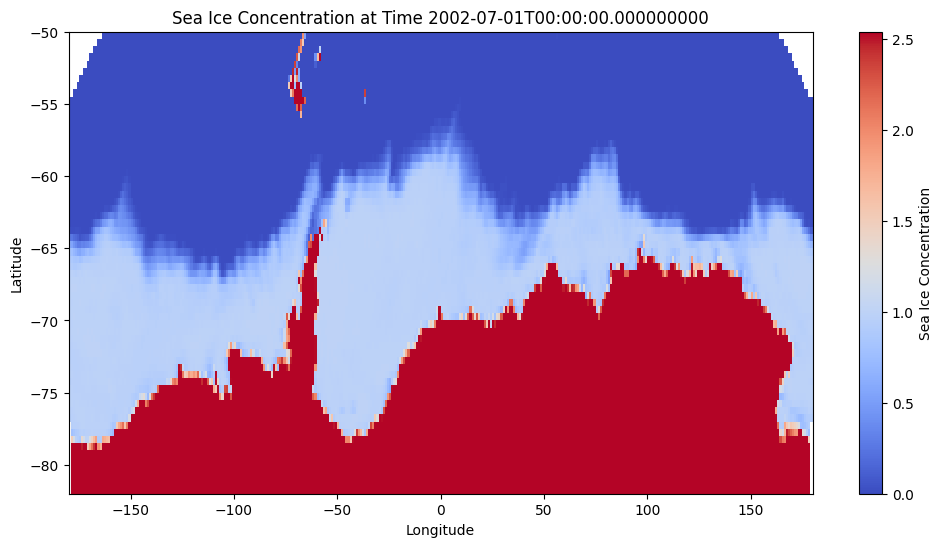

In [58]:
print(regridded_seaice_ds)

# Extract the time, latitude, and longitude coordinates
time_values = regridded_seaice_ds['time'].values
lat_values = regridded_seaice_ds['lat'].values
lon_values = regridded_seaice_ds['lon'].values

# Create a meshgrid for lat/lon coordinates for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

# Plot the sea ice concentration at time step 0 (you can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_conc[0], cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Concentration at Time {time_values[0]}')  # Use time label for title
plt.show()

Original max value in regridded: 2.539999961853028
Max value after masking in regridded_seaice_masked: 1.0


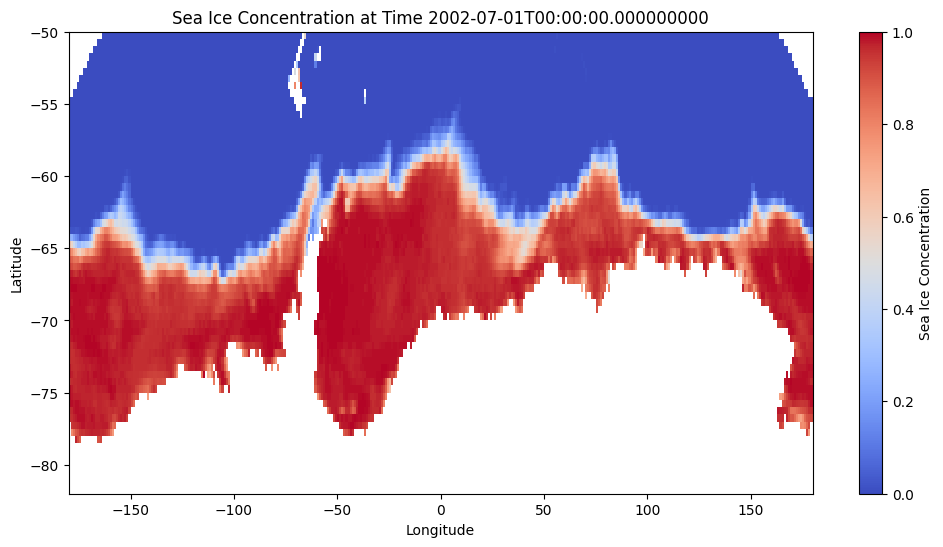

In [59]:

# Mask values > 1
regridded_seaice_filtered = np.where(regridded_seaice_conc >1,  np.nan, regridded_seaice_conc)

# Verify the masking
print("Original max value in regridded:", np.nanmax(regridded_seaice_conc))
print("Max value after masking in regridded_seaice_masked:", np.nanmax(regridded_seaice_filtered))

# Plot the sea ice concentration at time step 0 (you can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_filtered[0], cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Concentration at Time {time_values[0]}')  # Use time label for title
plt.show()


In [60]:
icemask = regridded_seaice_filtered[0].copy()/regridded_seaice_filtered[0]
icemask[icemask == 0] = np.nan

In [61]:
#apply the icemask
# Apply the mask to the entire seaice_detrended dataset
seaice_masked = regridded_seaice_filtered * icemask[np.newaxis, :, :]

In [62]:
#detrend seaice conc
# linear regression in time on each grid point
n_si,slope_si,intercept_si,p_val_si,r_square_si,rmse_si = linregress_3D(regridded_seaice_filtered)
# remove trend for dot
xt_si = np.zeros(regridded_seaice_filtered.shape)
for t in range(0,regridded_seaice_filtered.shape[0]):
    xt_si[t] = t
seaice_detrended = regridded_seaice_filtered - (slope_si*xt_si + intercept_si)
slope_si = slope_si.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si):", slope_si.shape)


Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si): (64, 360)


In [63]:
seaice_final = seaice_detrended.copy()

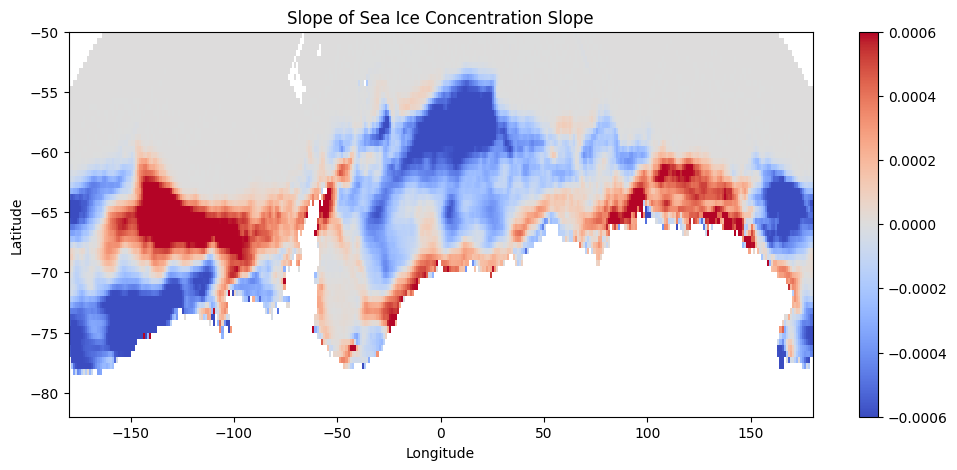

In [64]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope_si, vmin=-6e-4, vmax=6e-4, cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Sea Ice Concentration Slope')
plt.colorbar()

In [65]:
#DESEASONAL

In [66]:
#deseasonal for sea ice and dot
months = time_dot.astype('datetime64[M]').astype(int) % 12 + 1

In [67]:
# find and remove seasonality from dot_detrended and seaice_detrended
dot_seas = np.zeros((12,dot.shape[1],dot.shape[2])); seaice_seas = np.zeros((12,dot.shape[1],dot.shape[2]))
for m in range(1,13):
    dot_seas[m-1] = np.nanmean(dot_detrended[np.where(months==m)], axis=0)
    seaice_seas[m-1] = np.nanmean(seaice_detrended[np.where(months==m)], axis=0)

# remove seasonality from dot and sea ice concetration
dot_final = np.zeros(dot_detrended.shape); seaice_final = np.zeros(seaice_detrended.shape)
for i,m in enumerate(months):
    dot_final[i] = dot_detrended[i] - dot_seas[m-1]
    seaice_final[i] = seaice_detrended[i] - seaice_seas[m-1]

In [68]:
print("dot_detrended shape:", dot_detrended.shape)
print("seaice_detrended shape:", seaice_detrended.shape)
print("months shape:", months.shape)


dot_detrended shape: (196, 64, 360)
seaice_detrended shape: (196, 64, 360)
months shape: (196,)


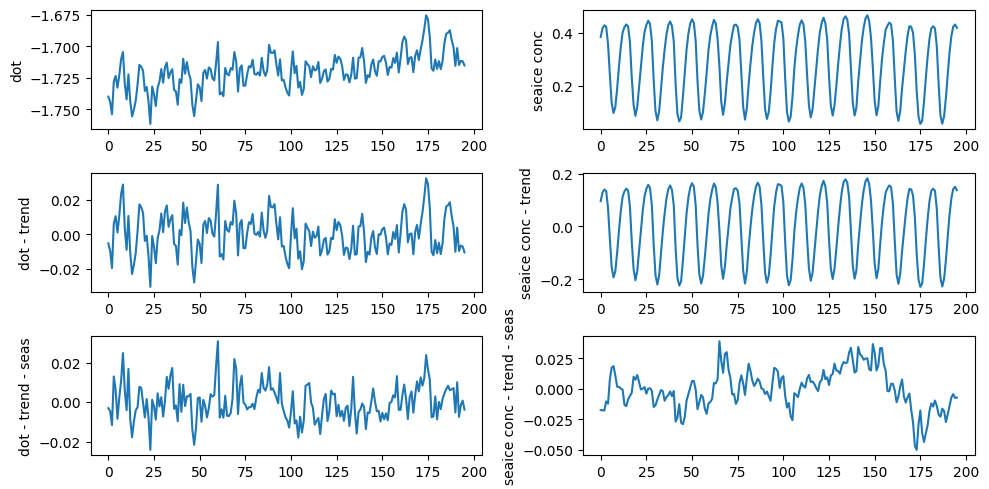

In [69]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.ylabel('seaice conc')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.ylabel('seaice conc - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(seaice_final, axis=(1,2)))
plt.ylabel('seaice conc - trend - seas')

plt.tight_layout()

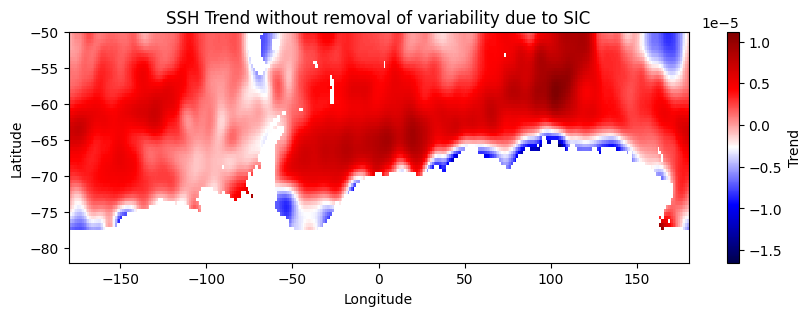

In [70]:
# SSH trends without removing ocean variability due to sea ice concentration
plt.figure(figsize=(10,3))
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot_final)
plt.pcolormesh(lon_mesh, lat_mesh, slope, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SSH Trend without removal of variability due to SIC')
cbar = plt.colorbar()
cbar.set_label('Trend')

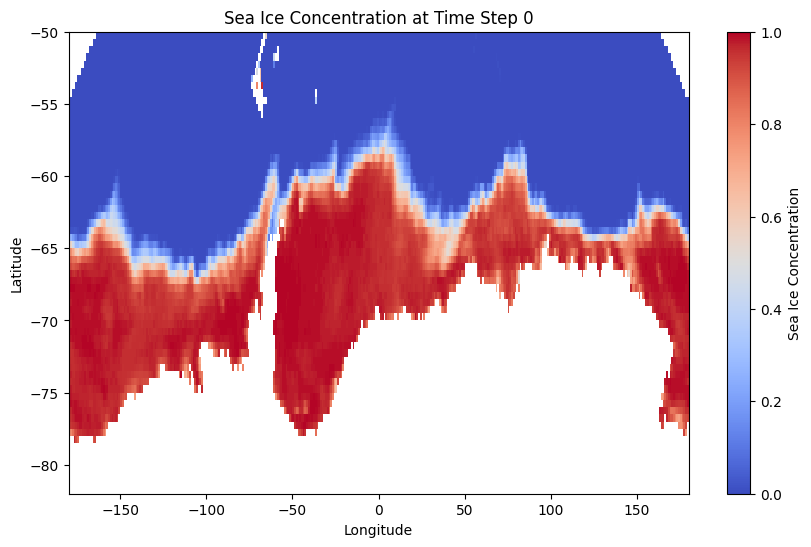

In [71]:
time_step = 0  # You can change this to any index from 0 to 195 (since the shape is (196, 64, 360))

# Extract and plot the masked data for the selected time step
seaice_at_t = regridded_seaice_filtered[time_step]


# Plot the data using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh( lon_mesh, lat_mesh,seaice_at_t, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.title(f"Sea Ice Concentration at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [72]:
# MCA

In [73]:
dot_xa = xr.DataArray(dot_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
seaice_xa = xr.DataArray(seaice_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)

# print(dot_xa.values)
# print('/n---/n')
# print(seaice_xa.values)

min_value = seaice_xa.where(~seaice_xa.isnull()).min().item()
max_value = seaice_xa.where(~seaice_xa.isnull()).max().item()
print(f"Range of values (excluding NaN): Min = {min_value}, Max = {max_value}")


Range of values (excluding NaN): Min = -0.9004445743067014, Max = 0.929343754111998


In [74]:
total_nans = dot_xa.isnull().sum().item()
print(f"Total NaN values in dot_xa: {total_nans}")

total_nans_seaice = seaice_xa.isnull().sum().item()
print(f"Total NaN values in seaice_xa: {total_nans_seaice}")

total_points_dot = dot_xa.size
print(f"Total data points in dot_xa: {total_points_dot}")

total_points_seaice = seaice_xa.size
print(f"Total data points in seaice_xa: {total_points_seaice}")

print(seaice_xa.shape)
print(dot_xa.shape)



Total NaN values in dot_xa: 1582308
Total NaN values in seaice_xa: 1554363
Total data points in dot_xa: 4515840
Total data points in seaice_xa: 4515840
(196, 64, 360)
(196, 64, 360)


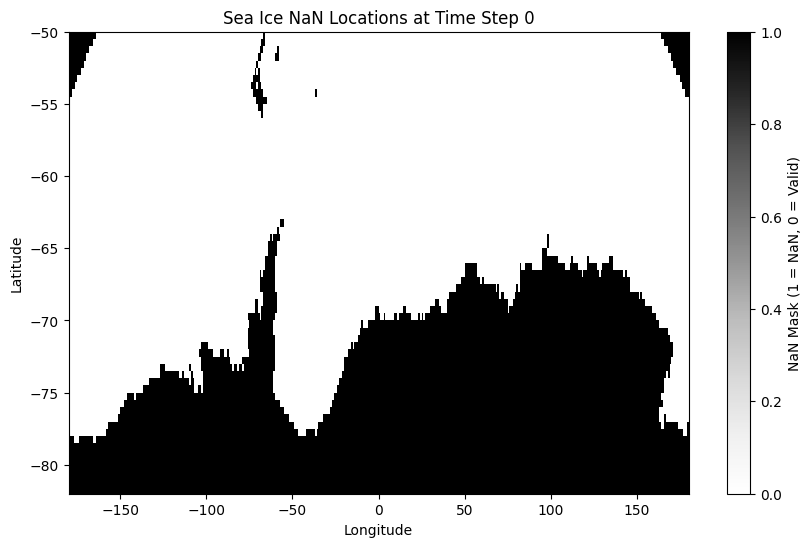

In [75]:
#plot where there are nan values (this is where i created the mask for SIC > 1 earlier)
time_step = 0
# Create a mask where NaN values are True
seaice_nan_mask = np.isnan(regridded_seaice_filtered[time_step])

# Plot the mask using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    lon_mesh, lat_mesh, seaice_nan_mask,
    cmap='Greys', shading='auto'
)
plt.colorbar(label='NaN Mask (1 = NaN, 0 = Valid)')
plt.title(f"Sea Ice NaN Locations at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [76]:
print(dir(xe))

['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [77]:
#set all NaN values to = 0 in dot and seaice. this means there has been no change
dot_xa_masked = dot_xa.fillna(0)
seaice_xa_masked = seaice_xa.fillna(0)

print("Masked dot_xa shape:", dot_xa_masked.shape)
print("Masked seaice_xa shape:", seaice_xa_masked.shape)

Masked dot_xa shape: (196, 64, 360)
Masked seaice_xa shape: (196, 64, 360)


In [78]:
print("Remaining NaNs in dot_xa_masked:", dot_xa_masked.isnull().sum().item())
print("Remaining NaNs in seaice_xa_masked:", seaice_xa_masked.isnull().sum().item())


Remaining NaNs in dot_xa_masked: 0
Remaining NaNs in seaice_xa_masked: 0


In [79]:
print(dir(xe))


['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [80]:
import inspect
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(dot_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


In [81]:
s1 = scores1.values; s2 = scores2.values
c1 = comps1.values; c2 = comps2.values

In [82]:
print(path)
print(gridtype)

/Users/iw2g24/PycharmProjects/SSH_project/
remapcon


In [83]:
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")

Directory already exists


In [84]:
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_dot_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0,i]}\t{s1[1,i]}\t{s1[2,i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_concentration_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0,i]}\t{s2[1,i]}\t{s2[2,i]}\n')
file.close()

In [85]:
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...

In [86]:
r_pears = []; p_pears = []
r_spear = []; p_spear = []
for m in range(1,5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2)); p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2)); p_spear.append(np.round(p, 2))

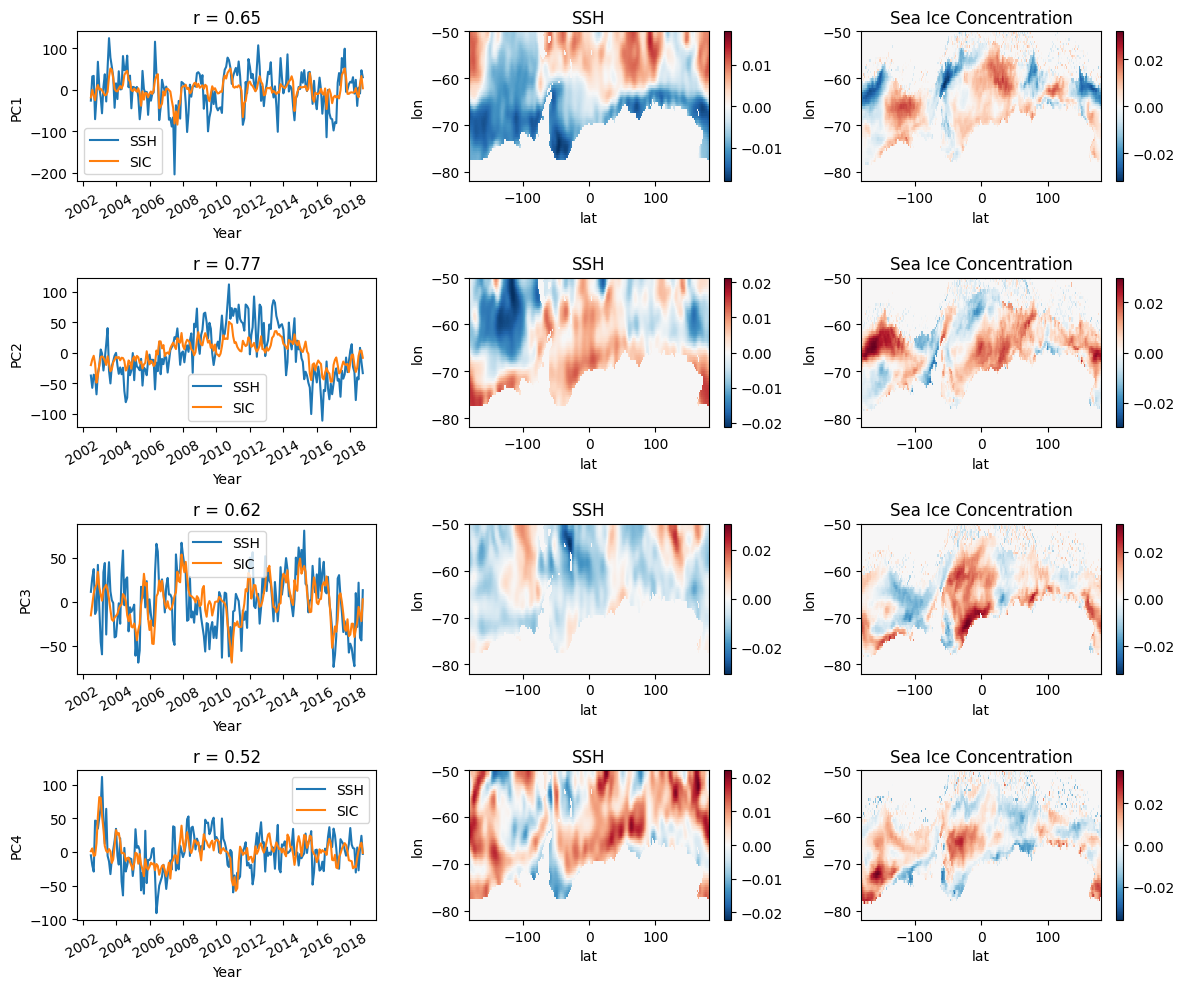

In [87]:
fig = plt.figure(figsize=(12,10))

for i in range(0,4):
    j = 3*i+1 # a = 2*(i+1) + i - 1
    
    plt.subplot(4,3,j)
    scores1.sel(mode=i+1).plot(label = 'SSH')
    scores2.sel(mode=i+1).plot(label = 'SIC')
    plt.title('r = ' +str(r_spear[i]))
    plt.xlabel('Year'); plt.ylabel('PC'+str(int(i+1)))
    plt.xticks(rotation=30) 
    plt.legend()
    
    plt.subplot(4,3,j+1)
    comps1.sel(mode=i+1).plot()
    plt.title('SSH')
    
    plt.subplot(4,3,j+2)
    comps2.sel(mode=i+1).plot()
    plt.title('Sea Ice Concentration')

fig.tight_layout()

fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')

In [88]:
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:',scf)

Cumulative sum of squares: [0.29258271 0.54855801 0.67256884 0.73206169 0.76754947 0.79924255
 0.82433703 0.84739656 0.86553575 0.88198547 0.8947634  0.90620479
 0.91657001 0.92506431 0.93205269 0.93858539 0.94460694 0.95035921
 0.95482861 0.9591715  0.96302435 0.96655895]
Squared covariance fraction: [0.29258271 0.2559753  0.12401083 0.05949284 0.03548778 0.03169308
 0.02509447 0.02305954 0.01813919 0.01644972 0.01277793 0.01144138
 0.01036522 0.0084943  0.00698838 0.00653271 0.00602154 0.00575227
 0.0044694  0.00434288 0.00385286 0.0035346 ]


In [89]:
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent =float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i]-cum_sum[i-1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


<class 'numpy.ndarray'>
22
PCA fraction [0.2925827106420583, 0.25597529892996773, 0.12401083174310235, 0.059492844062665196, 0.035487784551796686, 0.03169308280723249, 0.02509447247684271, 0.023059536282912463, 0.018139192846759356, 0.016449715219242544, 0.012777932735381858, 0.011441383074695777, 0.010365222634146742, 0.008494301438645047, 0.00698837655754625, 0.006532708812635679, 0.006021544255310984, 0.005752273660292295, 0.004469399534320684, 0.004342884082207288, 0.0038528555825585453, 0.0035346019701995024]
